<a href="https://colab.research.google.com/github/stephan-strate/sentiment-fine-foods/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import statistics

In [3]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/sentiment-fine-foods/sentiment-fine-foods.csv", delimiter=",", header=0)
print("Dataset has {:,} rows".format(df.shape[0]))

Dataset has 568,454 rows


In [4]:
df[["HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Text"]].sample(5)

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
87820,1,2,3,I reluctantly give this a 3 due mainly to the ...
114402,2,2,5,My family has been eating Molinari salame and ...
283816,1,1,5,Originally bought some of this in a store but ...
170087,3,3,5,These taste exactly the same as the ones that ...
134326,0,0,5,Great product. no complaints. Shipping was fas...


Clean data for future use with BERT
1. clean HTML tags from texts to prevent bloating of tokenizer, as BERT does not know HTML tags
2. remove duplicate reviews (using Text column)

In [5]:
size_dataset = len(df.index)

html_affected_rows = 0
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  if raw_html != cleantext:
    global html_affected_rows
    html_affected_rows += 1
  return cleantext

# clean html content of texts
df.Text = df.Text.apply(cleanhtml)
print("Cleaned {:,} rows from html ({} %)".format(html_affected_rows, round(html_affected_rows / size_dataset * 100)))

# removing duplicates
df.drop_duplicates(subset="Text", inplace=True)
rows_removed = size_dataset - len(df.index)
print("Removed {:,} duplicates ({} %)".format(rows_removed, round(rows_removed / size_dataset * 100)))

Cleaned 147,324 rows from html (26 %)
Removed 174,900 duplicates (31 %)


In [6]:
print("Dataset size after cleaning: {:,} / {:,} rows ({} %)".format(len(df.index), size_dataset, round(len(df.index) / size_dataset * 100)))

Dataset size after cleaning: 393,554 / 568,454 rows (69 %)


Analyse data regarding helpfulness

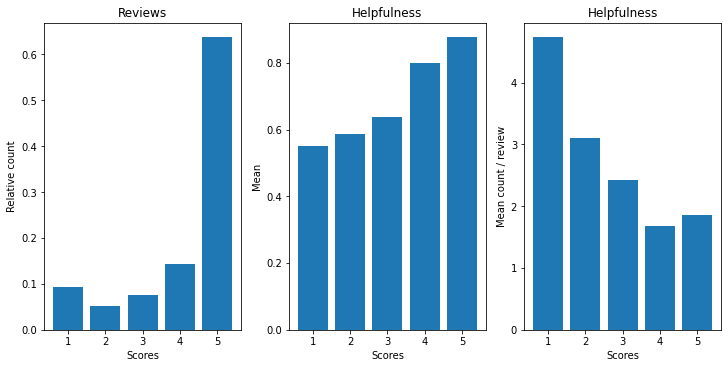

In [8]:
label_values = set(df.Score.values)

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(10, 5))

label_value_counts = df.Score.value_counts()
axs[0].bar(list(map(str, label_values)), list(map(lambda x: label_value_counts.get(x) / len(df.index), label_values)))
axs[0].set_title("Reviews")
axs[0].set_xlabel("Scores")
axs[0].set_ylabel("Relative count")

def mean_helpfulness(label):
  subset = df[df.Score.eq(label)]
  return statistics.mean(filter(lambda x: x is not None, map(lambda index: index.HelpfulnessNumerator / index.HelpfulnessDenominator if index.HelpfulnessDenominator > 0 else None, subset.itertuples(index=True))))

axs[1].bar(list(map(str, label_values)), list(map(mean_helpfulness, label_values)))
axs[1].set_title("Helpfulness")
axs[1].set_xlabel("Scores")
axs[1].set_ylabel("Mean")

def count_helpful(label):
  subset = df[df.Score.eq(label)]
  return sum(map(lambda index: index.HelpfulnessDenominator, subset.itertuples(index=True))) / len(subset.values)

axs[2].bar(list(map(str, label_values)), list(map(count_helpful, label_values)))
axs[2].set_title("Helpfulness")
axs[2].set_xlabel("Scores")
axs[2].set_ylabel("Mean count / review")

plt.show()

For BERT it is important to determine a plausible input length of word embeddings. That is why we need to take a look at some statistics about review length (word count).

We will overestimate the input token length in this case, because the input will probably contain some unknown words and therefore the tokenizer will split words into multiple parts.

**Length:** 128

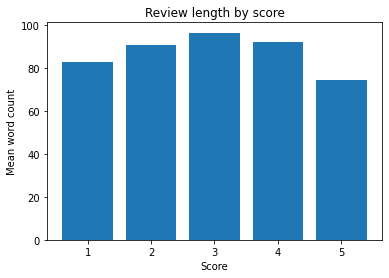

In [10]:
groups = df.groupby("Score")

plt.bar(list(map(str, label_values)), list(map(lambda x: np.mean(list(map(lambda y: len(y.split(" ")), x[1].Text.values))), groups)))
plt.xlabel("Score")
plt.ylabel("Mean word count")
plt.title("Review length by score")
plt.show()

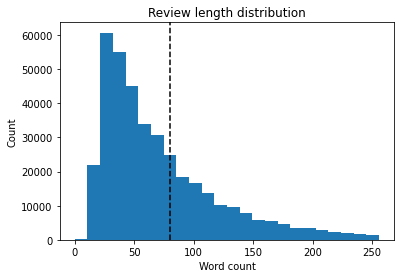

Mean review word count: 80.3254470796892 tokens


In [19]:
word_counts = np.array(list(map(lambda x: len(x.split(" ")), df.Text.values)))
plt.hist(word_counts, range=(0, 256), bins=24)
plt.axvline(word_counts.mean(), color="k", linestyle="dashed")

plt.xlabel("Word count")
plt.ylabel("Count")
plt.title("Review length distribution")
plt.show()

print("Mean review word count: {} tokens".format(word_counts.mean()))